In [1]:
import astrofix
import numpy as np
from scipy.signal import convolve
from astropy.io import fits
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib import rc
from mpl_toolkits.axes_grid1 import make_axes_locatable
rc('font',**{'family':'serif','serif':['Palatino'],'size': 20})
rc('lines', **{'linewidth':3.0})
rc('axes', **{'labelsize':28})

The example uses two V-band images: one shows the globular cluster 47 Tucanae, and the other shows the globular cluster Messier 15. Both images were taken by the LCO 0.4-meter telescope. They are available at:  
47 Tuc: [link]  
M15: [link]

Let's begin with the image of 47 Tucanae:

In [11]:
Tuc47 = fits.open('cpt0m407-kb84-20201027-0157-e91.fits.fz')[1].data
print(Tuc47.shape)

(2042, 3054)


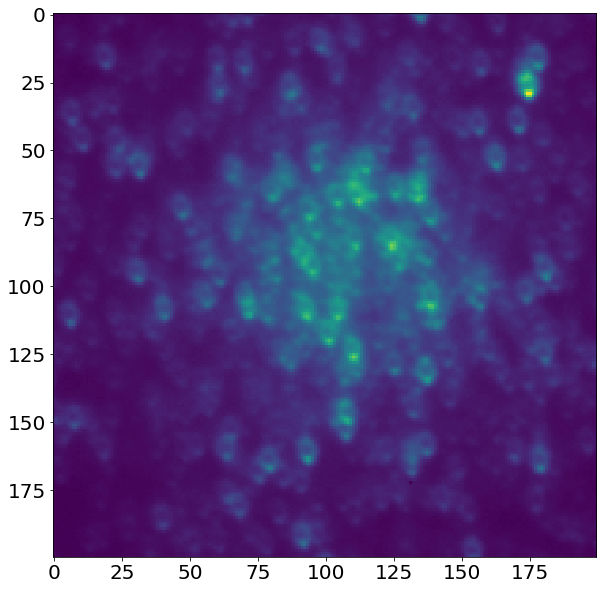

In [12]:
plt.figure(figsize=(10,10))
plt.imshow(Tuc47[950:1150,1400:1600])
plt.show()

To show **astrofix**'s performance on repairing the image, we randomly generate some artificial bad pixels. Let's say we turn 1% of all pixels into NaN. Half of the them stand alone, and the other half of them form crossed shaped regions of bad pixels. You can experiment with other bad pixel fractions and shapes.

In [13]:
img=Tuc47.copy().astype(float)
# 0.5% bad pixel
BP_mask=np.random.rand(img.shape[0],img.shape[1])>0.995
# 0.1% cross shaped regions of bad pixels
cross_mask=np.random.rand(img.shape[0],img.shape[1])>0.999
cross_generator=np.array([[0,1,0],[1,1,1],[0,1,0]])
BP_mask=(BP_mask+convolve(cross_mask,cross_generator,mode="same",method="direct"))!=0
img[BP_mask]=np.nan
print("Number of Bad Pixels: {}".format(np.count_nonzero(BP_mask)))

Number of Bad Pixels: 62677


The image is now populated by NaN pixels:

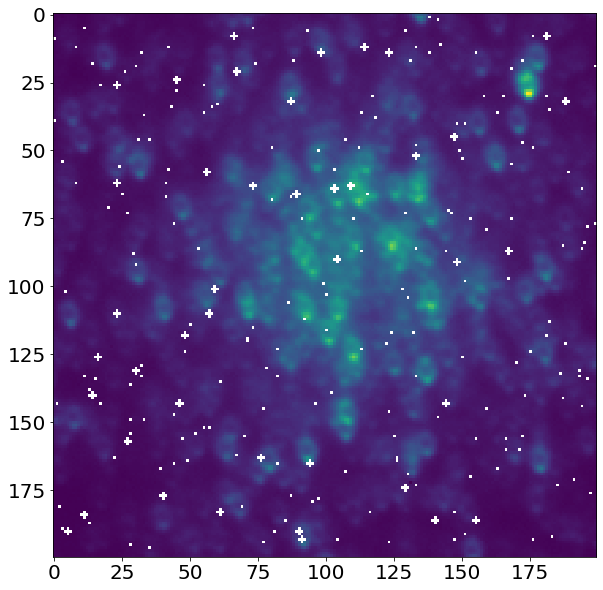

In [14]:
plt.figure(figsize=(10,10))
plt.imshow(img[950:1150,1400:1600])
plt.show()

Now let's repair the image with **astrofix.Fix_Image**:

In [15]:
# Because there is almost no saturation in this image, we set max_clip=1 so that we keep the brightest pixels in the training set.
fixed_img,para,TS=astrofix.Fix_Image(img,"asnan",max_clip=1)
print("a={},h={}".format(para[0],para[1]))
print("Number of training set pixels: {}".format(np.count_nonzero(TS)))

a=3.4596012869301256,h=1.4336702925651001
Number of training set pixels: 265476


Compare with the original image of 47 Tucanae:

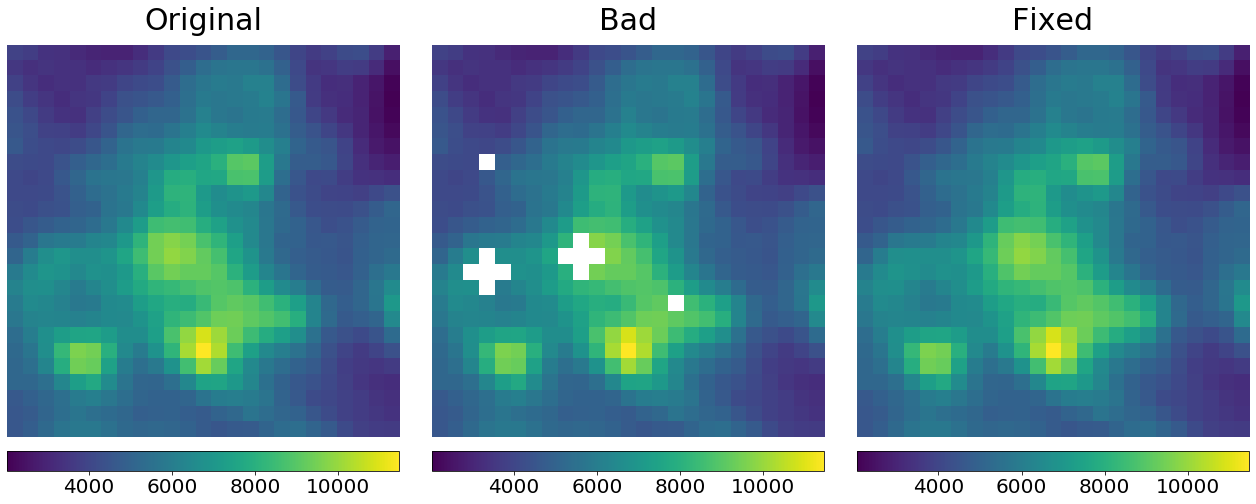

In [16]:
fig,ax=plt.subplots(1,3,figsize=(18,7))
im=ax[0].imshow(Tuc47[1000:1025,1500:1525]) # Choose your region to zoom in
divider = make_axes_locatable(ax[0])
cax = divider.append_axes("bottom", size="5%", pad=0.2)
fig.colorbar(im,ax=ax[0],cax=cax,orientation="horizontal")
ax[0].set_title("Original",fontsize=30,pad=15)
ax[0].axis("off")
im=ax[1].imshow(img[1000:1025,1500:1525])
divider = make_axes_locatable(ax[1])
cax = divider.append_axes("bottom", size="5%", pad=0.2)
fig.colorbar(im,ax=ax[1],cax=cax,orientation="horizontal")
ax[1].set_title("Bad",fontsize=30,pad=15)
ax[1].axis("off")
im=ax[2].imshow(fixed_img[1000:1025,1500:1525])
divider = make_axes_locatable(ax[2])
cax = divider.append_axes("bottom", size="5%", pad=0.2)
fig.colorbar(im,ax=ax[2],cax=cax,orientation="horizontal")
ax[2].set_title("Fixed",fontsize=30,pad=15)
ax[2].axis("off")
plt.tight_layout()
plt.show()

One feature of **astrofix** is that the training result for one image is usually applicable to similar images taken by the same telescope, meaning that we can repair the image of M15 without having to train on M15, simply using the optimal parameters that we got previously from 47 Tucanae:

In [17]:
M15 = fits.open('cpt0m407-kb84-20201021-0084-e91.fits.fz')[1].data
print(M15.shape)

(2042, 3054)


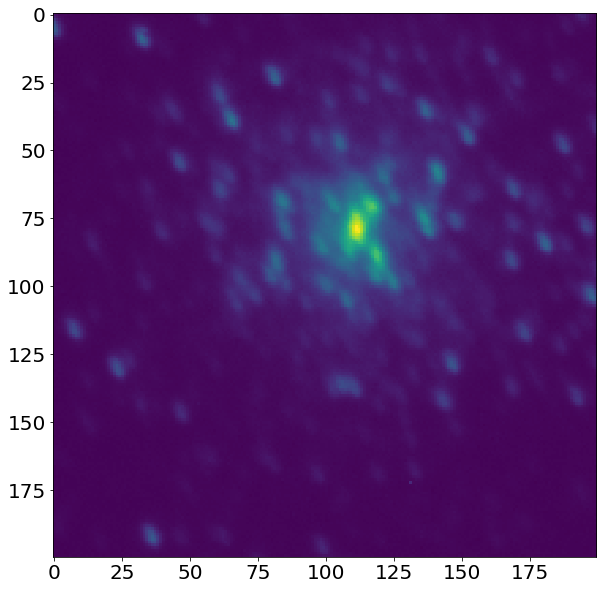

In [26]:
plt.figure(figsize=(10,10))
plt.imshow(M15[950:1150,1400:1600])
plt.show()

Generate artificial bad pixels like before:

Number of Bad Pixels: 63046


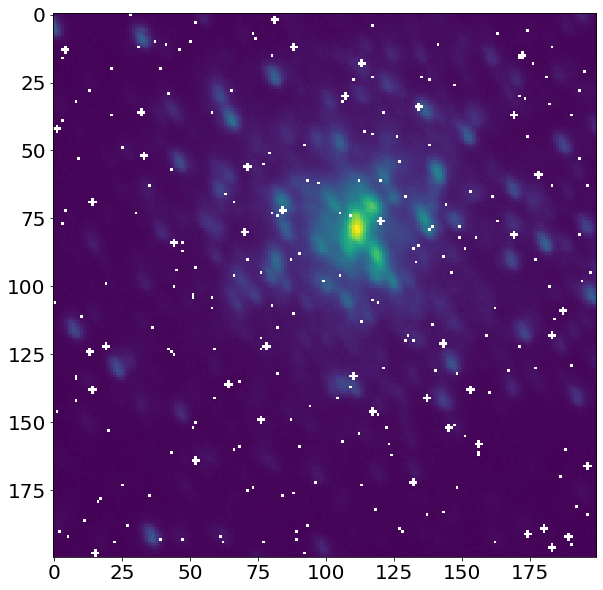

In [43]:
new_img=M15.copy().astype(float)
# 0.5% bad pixel
new_BP_mask=np.random.rand(new_img.shape[0],new_img.shape[1])>0.995
# 0.1% cross shaped regions of bad pixels
new_cross_mask=np.random.rand(new_img.shape[0],new_img.shape[1])>0.999
cross_generator=np.array([[0,1,0],[1,1,1],[0,1,0]])
new_BP_mask=(new_BP_mask+convolve(new_cross_mask,cross_generator,mode="same",method="direct"))!=0
new_img[new_BP_mask]=np.nan
print("Number of Bad Pixels: {}".format(np.count_nonzero(new_BP_mask)))
plt.figure(figsize=(10,10))
plt.imshow(new_img[950:1150,1400:1600])
plt.show()

This time, instead of calling **astrofix.Fix_image**, we use **astrofix.Interpolate** with $a$ and $h$ equal to their optimal values  for 47 Tucanae.

In [44]:
new_fixed_img=astrofix.Interpolate(para[0],para[1],new_img,BP="asnan")

Compare with the original image of M15:

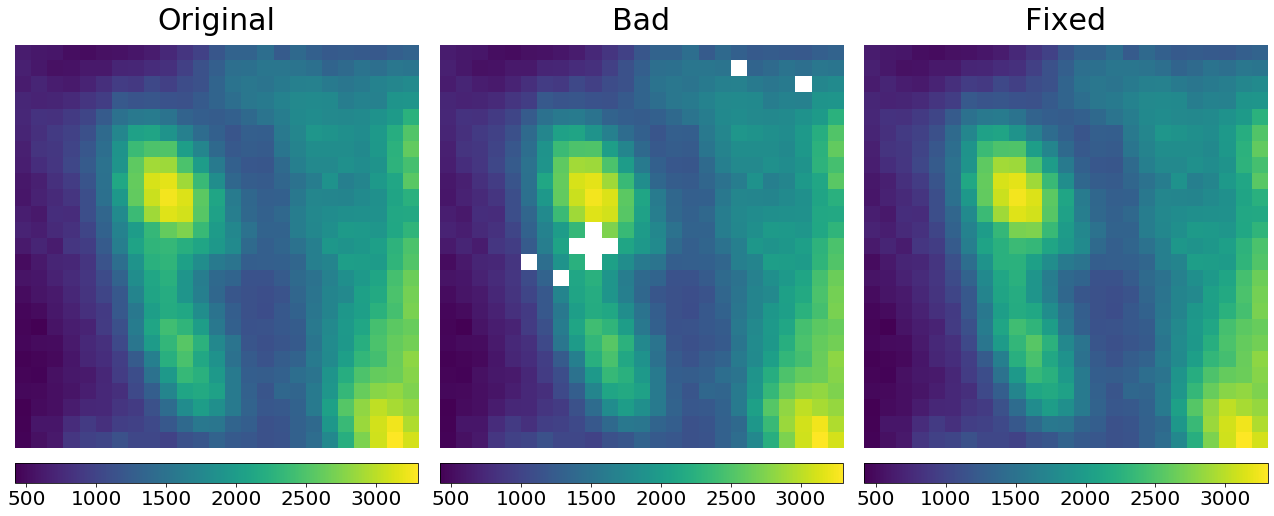

In [45]:
fig,ax=plt.subplots(1,3,figsize=(18,7))
im=ax[0].imshow(M15[1010:1035,1475:1500]) # Choose your region to zoom in
divider = make_axes_locatable(ax[0])
cax = divider.append_axes("bottom", size="5%", pad=0.2)
fig.colorbar(im,ax=ax[0],cax=cax,orientation="horizontal")
ax[0].set_title("Original",fontsize=30,pad=15)
ax[0].axis("off")
im=ax[1].imshow(new_img[1010:1035,1475:1500])
divider = make_axes_locatable(ax[1])
cax = divider.append_axes("bottom", size="5%", pad=0.2)
fig.colorbar(im,ax=ax[1],cax=cax,orientation="horizontal")
ax[1].set_title("Bad",fontsize=30,pad=15)
ax[1].axis("off")
im=ax[2].imshow(new_fixed_img[1010:1035,1475:1500])
divider = make_axes_locatable(ax[2])
cax = divider.append_axes("bottom", size="5%", pad=0.2)
fig.colorbar(im,ax=ax[2],cax=cax,orientation="horizontal")
ax[2].set_title("Fixed",fontsize=30,pad=15)
ax[2].axis("off")
plt.tight_layout()
plt.show()